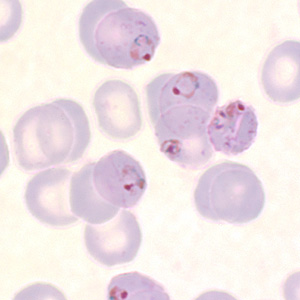

In [4]:
# Standard imports
import cv2
import numpy as np
from scipy import ndimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from PIL import Image
import os
import random

path2images = '~/tmp/malaria/cdc_falciparum/'
img = os.path.join(path2images, random.choice(os.listdir(path2images)))

# Read image
image = cv2.imread(img)

Image.fromarray(image)

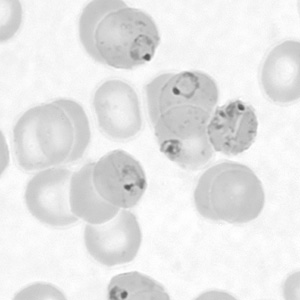

In [5]:
#convert to grayscale 
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
Image.fromarray(gray)

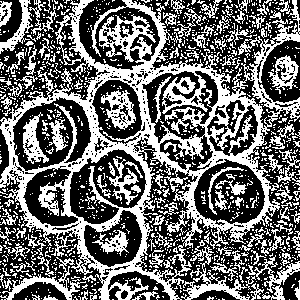

In [6]:
#threshold
thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,0)
#thresh = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,3,0)
Image.fromarray(thresh)

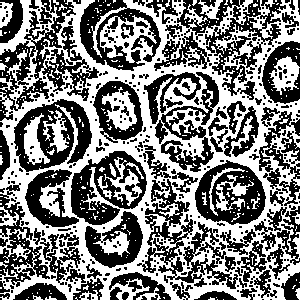

In [7]:
# closing
kernel = np.ones((2,2),np.uint8)
closed = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
Image.fromarray(closed)

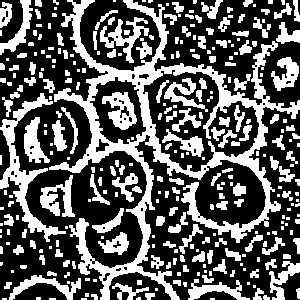

In [8]:
# opening
kernel = np.ones((3,3),np.uint8)
opened = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
Image.fromarray(opened)

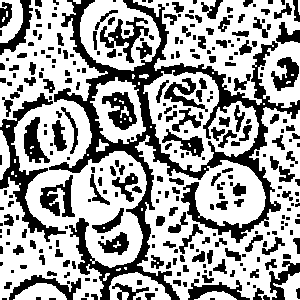

In [9]:
#invert
newimg = cv2.bitwise_not(opened)
Image.fromarray(newimg)

In [10]:
#find contours of white objects
im2, contours, hierarchy = cv2.findContours(newimg,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

In [11]:
#filling the "holes" of the white objects (red blood cells). 
#This is needed for proper segmentation with the watershed algorithm
for cnt in contours:
    cv2.drawContours(newimg,[cnt],0,255,-1)

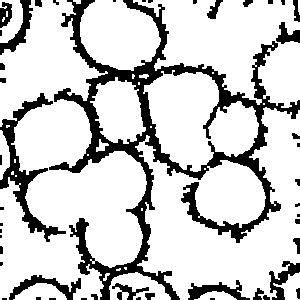

In [12]:
Image.fromarray(newimg)

In [13]:
# compute the exact Euclidean distance from every binary
# pixel to the nearest zero pixel, then find peaks in this
# distance map
D = ndimage.distance_transform_edt(newimg)
localMax = peak_local_max(D, indices=False, min_distance=20,
	labels=newimg)
 
# perform a connected component analysis on the local peaks,
# using 8-connectivity, then appy the Watershed algorithm
markers = ndimage.label(localMax, structure=np.ones((3, 3)))[0]
labels = watershed(-D, markers, mask=newimg)
print("[INFO] {} unique segments found".format(len(np.unique(labels)) - 1))

[INFO] 18 unique segments found


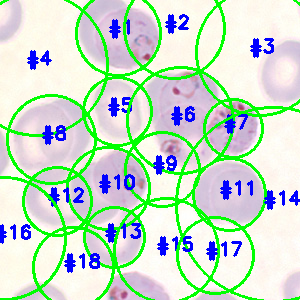

In [14]:
# loop over the unique labels returned by the Watershed
# algorithm
for label in np.unique(labels):
	# if the label is zero, we are examining the 'background'
	# so simply ignore it
	if label == 0:
		continue
 
	# otherwise, allocate memory for the label region and draw
	# it on the mask
	mask = np.zeros(gray.shape, dtype="uint8")
	mask[labels == label] = 255
 
	# detect contours in the mask and grab the largest one
	cnts = cv2.findContours(mask.copy(), cv2.RETR_EXTERNAL,
		cv2.CHAIN_APPROX_SIMPLE)[-2]
	c = max(cnts, key=cv2.contourArea)
 
	# draw a circle enclosing the object
	((x, y), r) = cv2.minEnclosingCircle(c)
	cv2.circle(image, (int(x), int(y)), int(r), (0, 255, 0), 2)
	cv2.putText(image, "#{}".format(label), (int(x) - 10, int(y)),
		cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

Image.fromarray(image)